Statistical Theory - Final Project : Student Alcohol Consumption


Authors: Shilo Avital & Sarel Lieberman

Date:    10.7.2025

Python:  3.11

In [158]:
from pathlib import Path
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.miscmodels.ordinal_model import OrderedModel
from scipy.stats import kruskal
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import (
    roc_auc_score, roc_curve,
    confusion_matrix, accuracy_score,
    classification_report
)
from sklearn.linear_model import LogisticRegression

In [159]:
# Plotting style
plt.rcParams.update({
    "figure.dpi": 300,
    "savefig.dpi": 300,
    "axes.titlesize": 11,
    "axes.labelsize": 10,
    "legend.fontsize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
})

In [160]:
def save_figure(fig, filename: Path):
    """Save and close a matplotlib figure."""
    fig.tight_layout()
    fig.savefig(filename, bbox_inches='tight')
    plt.close(fig)
    print(f"[FIG] Saved → {filename}")

In [161]:
def question_1(df, fout):
    """Q1 - Alcohol consumption vs grades."""
    fout.write("Q1: Alcohol consumption vs grades\n")

    # Pearson correlation
    r, p = stats.pearsonr(df['Walc'], df['G3'])
    fout.write(f" Pearson r (Walc vs G3) = {r:.3f},  p = {p:.4g}\n")

    # Perform ANOVA
    model = smf.ols('G3 ~ C(Walc)', data=df).fit()
    anova = sm.stats.anova_lm(model, typ=2)
    fout.write(" ANOVA on G3 ~ C(Walc):\n")
    fout.write(anova.to_string()); fout.write("\n\n")

    # Tukey's HSD post hoc test
    tukey = pairwise_tukeyhsd(endog=df['G3'], groups=df['Walc'], alpha=0.05)
    fout.write(" Tukey HSD results:\n")
    fout.write(str(tukey)); fout.write("\n\n")

    df['Walc'] = df['Walc'].astype(int)
    frequent_drinkers = df[df['Walc'] > 3]['G3']
    non_frequent_drinkers = df[df['Walc'] <= 3]['G3']
    u_statistic, p_value = stats.mannwhitneyu(
    frequent_drinkers, non_frequent_drinkers, alternative="less"
    )
    fout.write(f"\nQ1: U-statistic: {u_statistic:.4f}, P-value: {p_value:.6f}\n")
    if p_value < 0.05:
        fout.write("Conclusion: There is a significant difference in G3 between frequent and non-frequent drinkers.\n")
    else:
        fout.write("Conclusion: No significant difference in G3 between groups.\n")
    

    fig, ax = plt.subplots(figsize=(4.2, 3))
    sns.boxplot(data=df, x='Walc', y='G3', hue='Walc', palette='Blues', ax=ax, legend=False)
    ax.set_xlabel("Weekend alcohol use (1 = none … 5 = heavy)")
    ax.set_ylabel("Final grade (G3)")
    ax.set_title("Grades by weekend alcohol use")
    save_figure(fig, Path("figures/Q1_G3_Walc_boxplot.png"))

    # plot a scatter plot with regression line for all the data
    fig, ax = plt.subplots(figsize=(4.2, 3))
    sns.regplot(data=df, x='Walc', y='G3', ax=ax, scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})
    ax.set_xlabel("Weekend alcohol use (1 = none … 5 = heavy)")
    ax.set_ylabel("Final grade (G3)")
    ax.set_title("Grades by weekend alcohol use (regression)")
    save_figure(fig, Path("figures/Q1_G3_Walc_regression.png"))

In [162]:
def question_2(df, fout):
    """Q2 - absences vs grades."""

    df['Pstatus'] = df['Pstatus'].map({'T': 1, 'A': 0})
    df['famsup'] = df['famsup'].map({'yes': 1, 'no': 0})
    df['romantic'] = df['romantic'].map({'yes': 1, 'no': 0})

    # Define predictors and outcome
    X = df[['Fedu', 'Medu', 'Pstatus', 'famsup', 'romantic']]
    y = df['Walc']

    # 2. Fit the full model
    mod = OrderedModel(endog=y, exog=X, distr='logit')
    res = mod.fit(method='bfgs', disp=False)

    # 3. Build R for a joint test β1=…=β5=0
    k_exog = X.shape[1]              # = 5
    p_total = len(res.params)        # = 5 slopes + 4 thresholds = 9

    # Initialize R as zeros (5 constraints × 9 params)
    R = np.zeros((k_exog, p_total))

    # Place 1’s on the diagonal for the slope parameters
    for i in range(k_exog):
        R[i, i] = 1

    # (Optional) print to verify shape
    print("R shape:", R.shape)   # should be (5, 9)

    # 4. Run the Wald test
    wald_res = res.wald_test(R, scalar=True)

    # Extract and print results
    stat = float(wald_res.statistic)   # χ²
    df_num = int(wald_res.df_denom)      # should be 5
    pval = float(wald_res.pvalue)

    print(f"\nWald joint test of β1=…=β5=0")
    print(f"  χ²({df_num}) = {stat:.3f}, p = {pval:.4f}")
    if pval < 0.05:
        print("→ Reject H₀: predictors jointly explain the score.")
    else:
        print("→ Fail to reject H₀: no joint effect detected.")

In [163]:
def question_3(df, fout):
    """Q3: Check if among heavy drinkers home regarding parameters affect G3 (final grades)."""
    # Ensure categorical variables are encoded numerically
    df['Pstatus'] = df['Pstatus'].map({'T': 1, 'A': 0})
    df['famsup'] = df['famsup'].map({'yes': 1, 'no': 0})
    df['romantic'] = df['romantic'].map({'yes': 1, 'no': 0})
    df['schoolsup'] = df['schoolsup'].map({'yes': 1, 'no': 0})
    df['higher'] = df['higher'].map({'yes': 1, 'no': 0})

    # Filter for heavy drinkers
    df = df[df['Walc'] >= 4]

    predictors = ['Fedu', 'Medu', 'Pstatus', 'famsup',
                  'romantic', 'studytime', 'failures', 'schoolsup', 'higher', 'goout', 'absences']

    for col in predictors:
        # Get unique values in this predictor
        groups = [df[df[col] == val]['G3'] for val in df[col].unique()]
        stat, p = kruskal(*groups)
        print(
            f"Kruskal-Wallis for {col}: statistic={stat:.2f}, p-value={p:.4g}")

In [164]:

QUESTION_FUNCS = {
    "Q1": question_1,
    "Q2": question_2,
    "Q3": question_3,
}

In [165]:
def load_and_concat():
    math_df = pd.read_csv('data/student-mat.csv')
    por_df = pd.read_csv('data/student-por.csv')
    # concat dataframes vertically
    df = pd.concat([math_df, por_df], axis=0)
    return df

In [166]:
Path("figures").mkdir(exist_ok=True)
df_copy = load_and_concat()

In [167]:

with open("results_summary.txt", "w", encoding='utf-8') as fout:
    for q in QUESTION_FUNCS:
        print(f"\n=== Running {q} ===")
        df = df_copy.copy()
        QUESTION_FUNCS[q](df, fout)


=== Running Q1 ===
[FIG] Saved → figures\Q1_G3_Walc_boxplot.png
[FIG] Saved → figures\Q1_G3_Walc_regression.png

=== Running Q2 ===
R shape: (5, 9)

Wald joint test of β1=…=β5=0
  χ²(5) = 11.789, p = 0.0378
→ Reject H₀: predictors jointly explain the score.

=== Running Q3 ===
Kruskal-Wallis for Fedu: statistic=12.24, p-value=0.006607
Kruskal-Wallis for Medu: statistic=14.42, p-value=0.006081
Kruskal-Wallis for Pstatus: statistic=1.96, p-value=0.1619
Kruskal-Wallis for famsup: statistic=0.31, p-value=0.5808
Kruskal-Wallis for romantic: statistic=1.13, p-value=0.288
Kruskal-Wallis for studytime: statistic=0.19, p-value=0.98
Kruskal-Wallis for failures: statistic=47.38, p-value=2.886e-10
Kruskal-Wallis for schoolsup: statistic=1.45, p-value=0.2285
Kruskal-Wallis for higher: statistic=22.92, p-value=1.692e-06
Kruskal-Wallis for goout: statistic=6.62, p-value=0.1571
Kruskal-Wallis for absences: statistic=17.45, p-value=0.7379


In [168]:
# correlation matrix for Walc, G3, absences, Dalc, health, studytime. 
heavy_drinkers = df[df['Walc'] >= 4] 

corr_df = heavy_drinkers[['G3', 'Fedu', 'Medu', 'romantic', 'famsup', 'Pstatus']]
corr_matrix = corr_df.corr(method='pearson') 
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', ax=ax)
ax.set_title("Correlation Matrix")
save_figure(fig, Path("figures/correlation_matrix.png"))


[FIG] Saved → figures\correlation_matrix.png


AUC:      0.814
Accuracy: 0.785
Confusion matrix:
 [[122  10]
 [ 35  42]]

Classification report:
               precision    recall  f1-score   support

           0      0.777     0.924     0.844       132
           1      0.808     0.545     0.651        77

    accuracy                          0.785       209
   macro avg      0.792     0.735     0.748       209
weighted avg      0.788     0.785     0.773       209



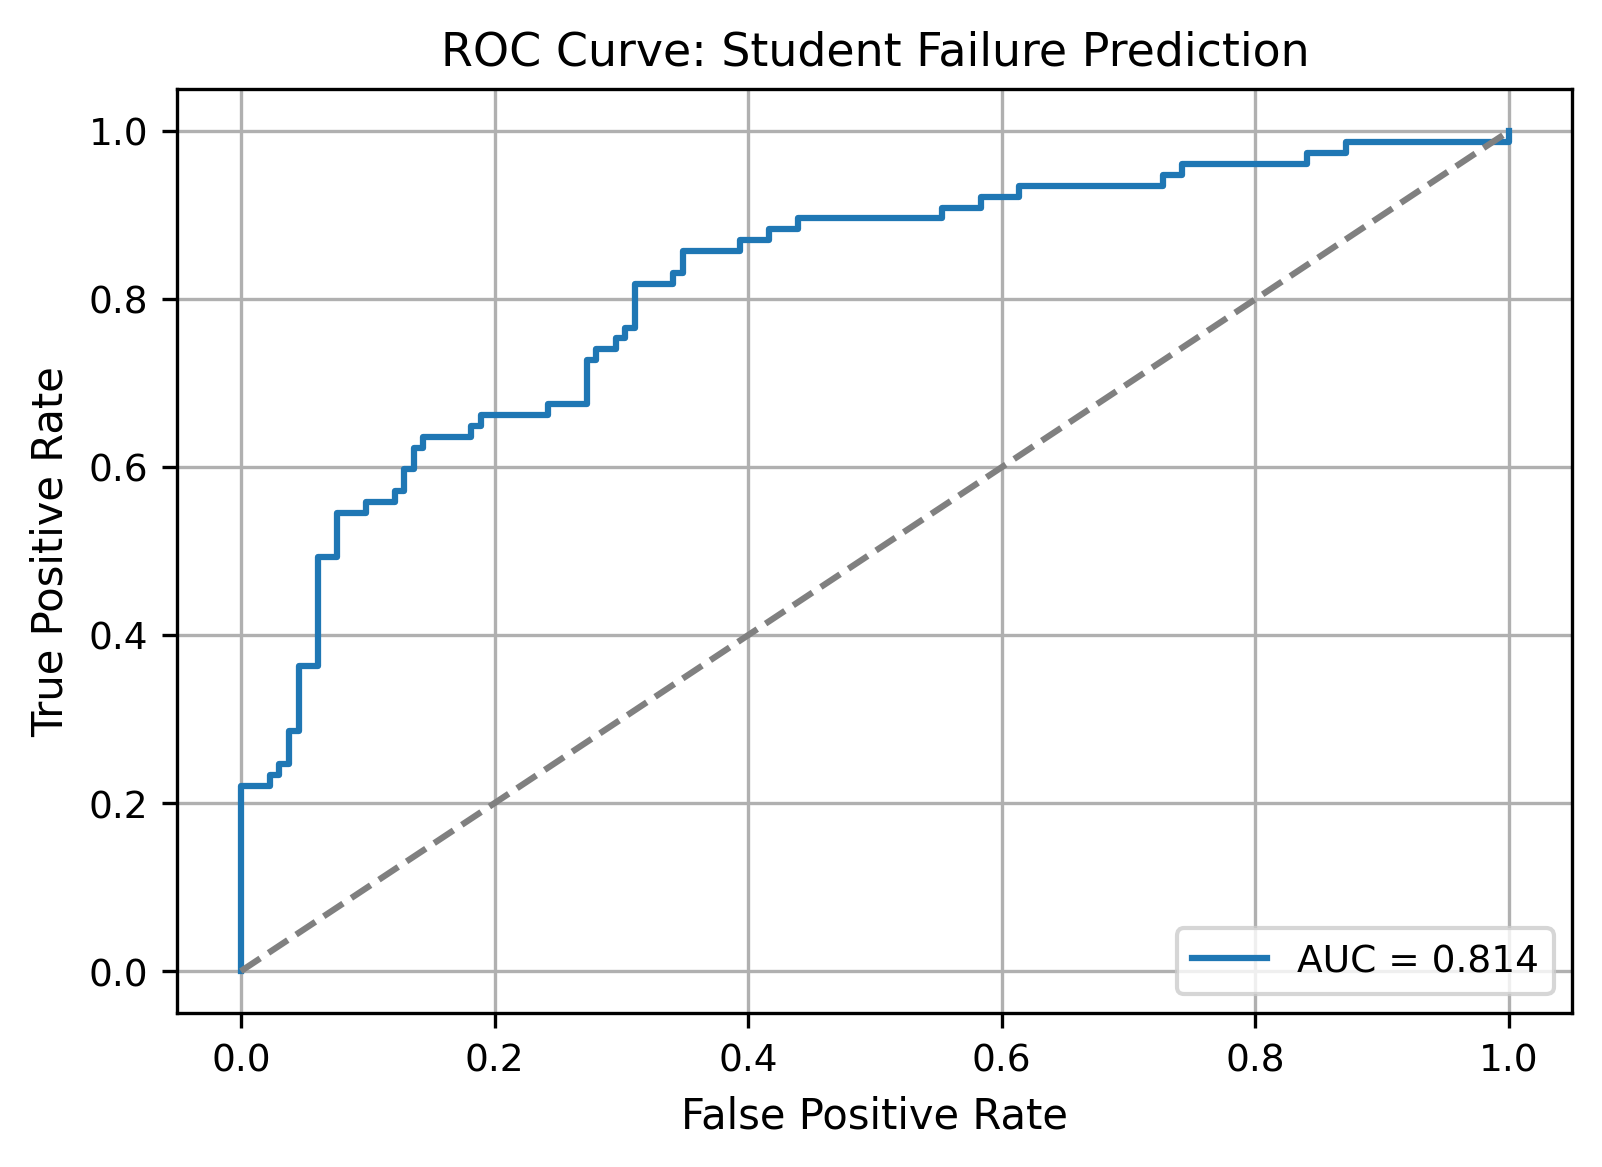

In [169]:
df = df_copy.copy()

# 2. Feature engineering
binary_map = {"yes":1, "no":0}
for col in ["famsup","schoolsup","romantic"]:
    df[col] = df[col].map(binary_map)

# Predictors and target
PREDICTORS = ["Walc","Dalc","absences","studytime","failures",
              "famsup","schoolsup","health","romantic"]
X = df[PREDICTORS]
y = (df["G3"] < 11).astype(int)  # 1=fail, 0=pass

# 3. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=269, stratify=y
    )

# 4. Pipeline: scale + logistic regression
pipe = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=10000, solver="lbfgs")
)
pipe.fit(X_train, y_train)

# 5. Predictions & metrics
y_prob = pipe.predict_proba(X_test)[:,1]
y_pred = (y_prob >= 0.5).astype(int)

auc = roc_auc_score(y_test, y_prob)
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, digits=3)

print(f"AUC:      {auc:.3f}")
print(f"Accuracy: {acc:.3f}")
print("Confusion matrix:\n", cm)
print("\nClassification report:\n", report)

# 6. Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1],[0,1],"--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: Student Failure Prediction")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
